## Reviewer Comments Demonstration

In [1]:
%load_ext autoreload
%autoreload 2

## DriftMLP is the package implementing this methodology
import DriftMLP
## h3 to convert locations to their h3 indices.
## Where possible we use DriftMLP.helpers.return_h3_inds()
import h3.api.basic_int as h3

## core python packages
import os
import numpy as np #
import pandas as pd
import pickle
import gc


## Matplotlib for plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

## Cartopy for map projections
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)


## geopandas for aid storing Polygons and plotting
import geopandas as gpd
from shapely.geometry import Polygon


import string
alphabet = string.ascii_lowercase


driftfile = os.environ['DRIFTFILE'] 


### Our example locations are in locations.txt
stations = np.loadtxt("locations.txt", delimiter=',')
stations = pd.DataFrame(stations, index=range(1, 8))
stations.columns = ['Longitude', 'Latitude']

stations.loc[:,['Longitude', 'Latitude']].to_latex()
gc.collect()
#print(sum([1 if len(i)>0 else 0 for i in network['stories']]))
#DriftMLP.helpers.add_link(network)

0

In [2]:
from DriftMLP.drifter_indexing.discrete_system import h3_default, lon_lat_grid
drift_gen = DriftMLP.driftiter.generator(driftfile, grid = [-90,27, -90,0])

discretizer_res3 = h3_default(res=3)
%time story_res3 = DriftMLP.story.get_story(drift_gen(variables = ["position", "drogue"], drogue=True), discretizer=discretizer_res3)
discretizer_res4 = h3_default(res=4)
%time story_res4 = DriftMLP.story.get_story(drift_gen(variables = ["position", "drogue"], drogue=True), discretizer = discretizer_res4)

story_and_dis = [(story_res3, discretizer_res3), (story_res4, discretizer_res4)]
for j in [0.5, 1, 1.5]:
    dis = lon_lat_grid(j)
    story = DriftMLP.story.get_story(drift_gen(variables = ["position", "drogue"], drogue=True), discretizer=dis)
    story_and_dis.append((story, dis))
networks_tl5 = [DriftMLP.form_network.make_transition(story) for story,_ in story_and_dis]

CPU times: user 32.5 s, sys: 277 ms, total: 32.8 s
Wall time: 32.9 s
CPU times: user 32.5 s, sys: 335 ms, total: 32.8 s
Wall time: 32.9 s
[True, True]
[True, True]
[True, True]


In [3]:
def add_gridlines(ax):
        gl = ax_current.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.right_labels = False
        gl.bottom_labels= False
        gl.xlines = False
        gl.xlocator = mticker.FixedLocator(list(range(-45,25,15)))#
        
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        #gl.xlabel_style = {'size': 15, 'color': 'gray'}
        #gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
        gl.ylocator = mticker.FixedLocator(list(range(-55,-10,10)))
        return gl

### For demonstration lets plot 10 bootstrapped pathways from each method going from 1->3 and vice versa

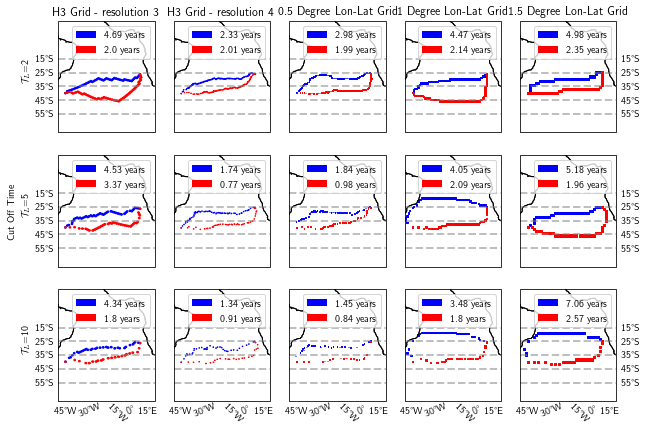

In [35]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(3, 5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[10,7])
loc1 = stations.iloc[0, [0,1]].to_list()
loc2 = stations.iloc[2, [0,1]].to_list()
titles = ["H3 Grid - resolution 3", "H3 Grid - resolution 4", "0.5 Degree Lon-Lat Grid", "1 Degree Lon-Lat Grid", "1.5 Degree Lon-Lat Grid" ]
#for T_L in range(5,10, 20)
sp_list_of_lists=[]


    
for ind, (story, discretizer) in enumerate(story_and_dis):
    sp_list=[]
    for row, cut_off in enumerate([2,5,10]):
        network = DriftMLP.form_network.make_transition(story, day_cut_off=cut_off)
        sp = DriftMLP.shortest_path.SingleSP(network, loc1, loc2, discretizer = discretizer)
        sp_list.append(sp)

        ax_current = ax[row, ind]
        ax_current.coastlines()                                                    
        sp.plot_cartopy(ax=ax_current)
        ax_current.set_extent([-50,20,-40,-10])
        if row==0:
            ax_current.set_title(f"{titles[ind]}")
        if ind==0:
            ax_current.text(-0.3, 0.55, '$\mathcal{T}_L$='+str(cut_off), va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax_current.transAxes)
        ax_current.legend(handles =[Patch(facecolor="blue", label=f"{round(sp.sp.travel_time/365,2)} years"),
                           Patch(facecolor="red", label=f"{round(sp.sp_rev.travel_time/365,2)} years")])
        gl = add_gridlines(ax_current)
        if row==2:
            gl.bottom_labels = True
        if ind==0:
            gl.left_labels = True
        elif ind==4:
            gl.right_labels = True
    sp_list_of_lists.append(sp_list)
fig.text(0.06, 0.5, 'Cut Off Time', ha='center', va='center', rotation='vertical')
fig.savefig(f"Images/grid_size_tt_results.pdf")

/home/omalley3/Documents/PhD_Docs/pydrifter_dev/DriftMLP/plotting/make_gpd.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_df['centroid_col'] = geo_df.centroid


5
5
5
5


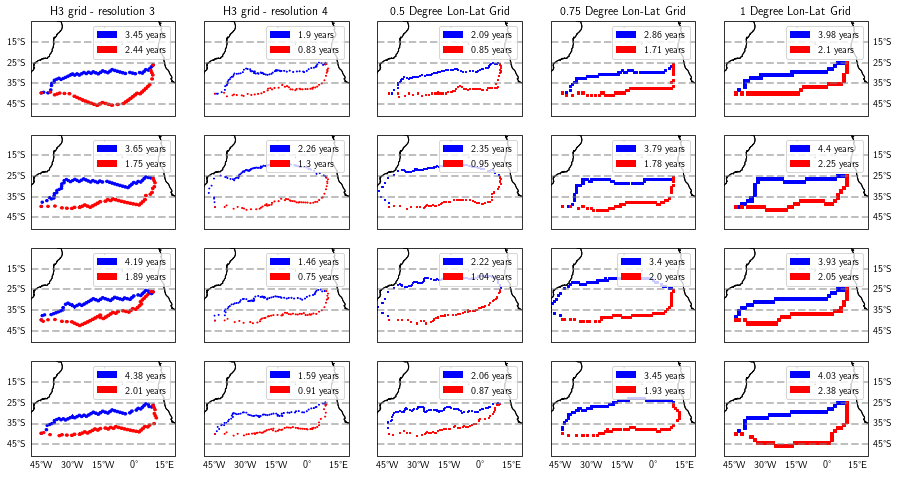

In [28]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(4,5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[11,6])
loc1 = stations.iloc[0, [0,1]].to_list()
loc2 = stations.iloc[2, [0,1]].to_list()
titles = ["H3 grid - resolution 3", "H3 grid - resolution 4", "0.5 Degree Lon-Lat Grid", "0.75 Degree Lon-Lat Grid", "1 Degree Lon-Lat Grid" ]
#for T_L in range(5,10, 20)
bootsp_list_of_lists = []
bootnetworks_list_of_lists = []
story_len = len(story_and_dis[0][0])
day_cut_off=5
tt_array = np.zeros((5,4,2))
assert all([len(story)==story_len for story,_ in story_and_dis])
for row in range(4):
    boot_inds = np.random.randint(0, story_len, size=story_len)
    bootstrap_networks = []
    bootstrap_paths = []
    for ind, (story, discretizer) in enumerate(story_and_dis):
        boot_story = [story[i] for i in boot_inds]
        boot_network = DriftMLP.form_network.make_transition(boot_story, day_cut_off=day_cut_off)
        
        sp = DriftMLP.shortest_path.SingleSP(boot_network, loc1, loc2, discretizer = discretizer)
        tt_array[ind, row, 0] = sp.sp.travel_time
        tt_array[ind, row, 1] = sp.sp_rev.travel_time
        bootstrap_networks.append(boot_network)
        bootstrap_paths.append(sp)
        ax_current = ax[row, ind]
        ax_current.coastlines()
   
        sp.plot_cartopy(ax=ax_current)
        ax_current.set_extent([-50,20,-40,-10])
        if row==0:
            ax_current.set_title(f"{titles[ind]}")
        if ind==0:
            ax_current.set_ylabel(f"Sample {row}")
        ax_current.legend(handles =[Patch(facecolor="blue", label=f"{round(sp.sp.travel_time/365,2)} years"),
                           Patch(facecolor="red", label=f"{round(sp.sp_rev.travel_time/365,2)} years")])
        gl = add_gridlines(ax_current)
        if row==3:
            gl.bottom_labels = True
        if ind==0:
            gl.left_labels = True
        elif ind==4:
            gl.right_labels = True
    print(len(bootstrap_paths))
    bootsp_list_of_lists.append(bootstrap_paths)
    bootnetworks_list_of_lists.append(bootstrap_networks)


fig.savefig("Images/grid_size_boot_results.pdf")

In [37]:
bootsp_resfirst = [[bootsp_list_of_lists[i][j] for i in range(4)] for j in range(5)]
travel_times = []
travel_times_reverse = []
for bootsp_list, network in zip(bootsp_resfirst, networks_tl5): 
    t_sums=[]
    reverse_times =[]
    for boot_sp in bootsp_list:      
        boot_sp.sp.update_nid(network)
        t_sum = sum(boot_sp.sp.expected_days(network))
        boot_sp.sp_rev.update_nid(network)
        rev_time = sum(boot_sp.sp_rev.expected_days(network))
        reverse_times.append(rev_time)
        #try:
        #    sp_object.sp.update_nid(boot_network)
        #    
            
        #except:
        #    print("node doesn't exist in new network")
        #    t_sum=0
        t_sums.append(t_sum)
    travel_times.append(t_sums)      
    travel_times_reverse.append(reverse_times)
travel_times = np.array(travel_times)
travel_times_reverse = np.array(travel_times_reverse)
            
        

In [38]:
print("Travel time from bootstrap sample (row)")
display(tt_array[:,:,0])
print("Same path, non-bootstrapped network")
display(travel_times)
print("Difference")
display(travel_times_reverse-tt_array[:,:,0])

Travel time from bootstrap sample (row)


array([[1257.42758293, 1331.55138384, 1529.83458847, 1597.15816277],
       [ 694.06103002,  825.40176586,  533.35864542,  579.01626523],
       [ 764.20705968,  859.42239663,  809.24390471,  751.74952383],
       [1044.51390261, 1384.65802388, 1241.06206784, 1259.24856809],
       [1451.59790433, 1605.28902175, 1433.02751473, 1471.46630891]])

Same path, non-bootstrapped network


array([[1676.04460088, 1928.45421716, 1947.31555081, 1842.68866405],
       [ 826.94430717, 1009.20000488,  731.72867381,  858.876887  ],
       [1089.37657058, 1191.8011348 , 1344.28660802, 1529.43908953],
       [1537.34666378, 1663.12568461, 1685.73907258, 1729.51555974],
       [1879.89392388, 1964.95062725, 1621.14834689, 1848.96426633]])

Difference


array([[ -73.65544135, -485.5290479 , -560.58327023, -755.4049377 ],
       [-192.79747475, -347.16485337, -168.09664762, -174.59197863],
       [-371.64699408, -334.64128753, -188.78121538, -329.37268208],
       [-171.70405252, -504.1514269 , -222.40196493, -318.31584755],
       [-525.35466204, -639.36504346, -579.91860016, -335.27997758]])

In [39]:
print("Travel time from bootstrap sample (row)")
display((tt_array[:,:,1]/365))
print("Same path, non-bootstrapped network")
display((travel_times_reverse/365))
print("difference")
display((travel_times_reverse-tt_array[:,:,1])/365)

Travel time from bootstrap sample (row)


array([[2.43910344, 1.75075767, 1.89225002, 2.00676563],
       [0.82912453, 1.29654539, 0.74959594, 0.91458073],
       [0.84824286, 0.94642271, 1.04078555, 0.87329265],
       [1.7054027 , 1.77798802, 2.00090689, 1.93255581],
       [2.09580321, 2.25363124, 2.04845968, 2.37835943]])

Same path, non-bootstrapped network


array([[3.24321135, 2.31786941, 2.65548306, 2.30617322],
       [1.37332481, 1.31023812, 1.0007178 , 1.10801174],
       [1.07550703, 1.43775646, 1.69989778, 1.15719683],
       [2.39125986, 2.41234684, 2.7908496 , 2.57789786],
       [2.53765272, 2.64636706, 2.3372847 , 3.11283926]])

difference


array([[0.80410791, 0.56711174, 0.76323304, 0.29940759],
       [0.54420028, 0.01369273, 0.25112186, 0.19343101],
       [0.22726417, 0.49133375, 0.65911223, 0.28390418],
       [0.68585717, 0.63435882, 0.78994271, 0.64534206],
       [0.44184951, 0.39273583, 0.28882502, 0.73447983]])

In [1]:
(story, discretizer), network =story_and_dis[1], network_tl5[1]
network = DriftMLP.form_network.make_transition(story, day_cut_off=cut_off)

NameError: name 'story_and_dis' is not defined